In [ ]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory


from IPython.display import display


In [ ]:
train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(resize, resize),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(resize, resize),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 900 files belonging to 1 classes.
Using 720 files for training.
Found 900 files belonging to 1 classes.
Using 180 files for validation.


In [ ]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

In [ ]:
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(lambda x: (process_input(x, input_size, upscale_factor), process_target(x)))
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(lambda x: (process_input(x, input_size, upscale_factor), process_target(x)))
valid_ds = valid_ds.prefetch(buffer_size=32)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>


In [ ]:
def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [ ]:
#building model
#Compared to the paper, they add one more layer and they used the relu activation function instead of tanh.
#It achieves better performance even though we train the model for fewer epochs.
def get_model(upscale_factor=2, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "glorot_uniform",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None,None, channels))
    x = layers.Conv2D(128, (5,5), **conv_args)(inputs)
    x = layers.Conv2D(64, (3,3), **conv_args)(x)
    x = layers.Conv2D(32, (3,3), **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [ ]:

early_stopping_callback1 = keras.callbacks.EarlyStopping(
    monitor="loss",  # Monitor training loss
    patience=5  # Stop training after 5 consecutive epochs without improvement
)

early_stopping_callback2 = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",  # Monitor validation accuracy
    patience=10  # Stop training after 10 consecutive epochs without improvement
)

checkpoint_filepath = "/content/drive/MyDrive/Colab Notebooks/Master_Thesis/ESPCN/ESPCNx2"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + '/x2.h5',
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

Mcallbacks = [early_stopping_callback1,early_stopping_callback2,model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
Moptimizer = keras.optimizers.Adam(learning_rate=0.0001)

ep = 150

model.compile(
    optimizer=Moptimizer, loss=loss_fn, metrics = ['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 128)   3328      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 4)     1156      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

In [ ]:
history = model.fit(
    train_ds, epochs=ep, callbacks=Mcallbacks, validation_data=valid_ds, verbose=1
)
history

Epoch 1/150
23/23 [==============================] - 107s 3s/step - loss: 0.1302 - accuracy: 0.0055 - val_loss: 0.0352 - val_accuracy: 0.0120
Epoch 2/150
23/23 [==============================] - 92s 3s/step - loss: 0.0208 - accuracy: 0.0081 - val_loss: 0.0136 - val_accuracy: 0.0120
Epoch 3/150
23/23 [==============================] - 96s 3s/step - loss: 0.0131 - accuracy: 0.0081 - val_loss: 0.0105 - val_accuracy: 0.0120
Epoch 4/150
23/23 [==============================] - 92s 3s/step - loss: 0.0106 - accuracy: 0.0081 - val_loss: 0.0085 - val_accuracy: 0.0120
Epoch 5/150
23/23 [==============================] - 90s 3s/step - loss: 0.0085 - accuracy: 0.0081 - val_loss: 0.0068 - val_accuracy: 0.0120
Epoch 6/150
23/23 [==============================] - 94s 3s/step - loss: 0.0069 - accuracy: 0.0082 - val_loss: 0.0056 - val_accuracy: 0.0120
Epoch 7/150
23/23 [==============================] - 95s 3s/step - loss: 0.0058 - accuracy: 0.0082 - val_loss: 0.0047 - val_accuracy: 0.0121
Epoch 8/150


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Master_Thesis/ESPCN/ESPCNx2/ESPCNx2.h5')

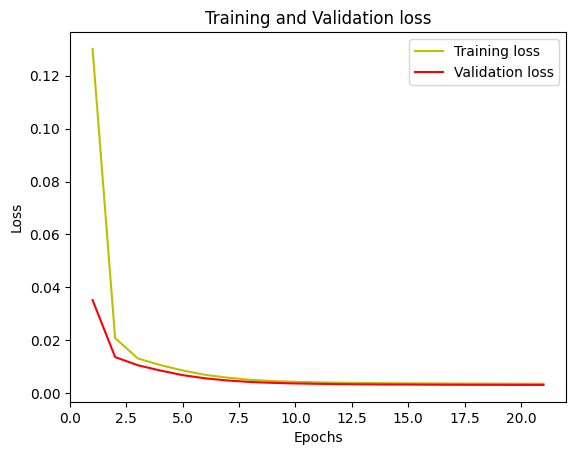

In [ ]:
loss = history.history['loss']

#plotting learning curve
epochs = range(1, len(loss) + 1)

#training and validation loss
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Master_Thesis/ESPCN/Results/x2/set5/Training_and_Validation_loss.png")
plt.show()

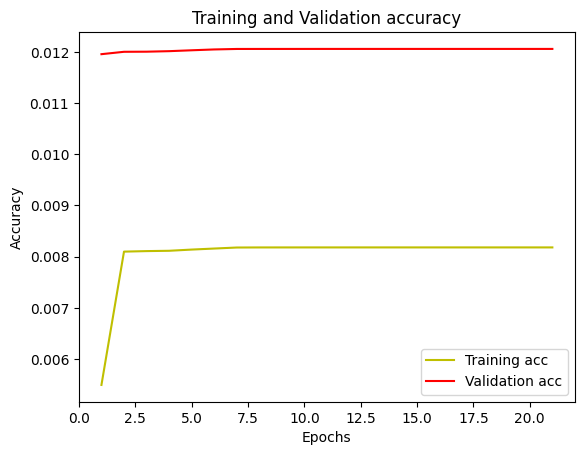

In [ ]:
#trainig and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Master_Thesis/ESPCN/Results/x2/set5/Training_and_Validation_accuracy.png")
plt.show()